In [1]:
#Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
#Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests 
from urllib.parse import urlencode 
import datetime
from scipy import stats
from scipy.stats import norm, mannwhitneyu
from scipy.stats import bootstrap
import datetime
%matplotlib inline
import pingouin as pg
from scipy import stats
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')

In [4]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [5]:
df.sort_values('revenue', ascending = False)



,user_id,revenue,testgroup
101861,101862,37433,a
196601,196602,37407,a
65077,65078,37394,a
21585,21586,37385,a
142804,142805,37379,a
...,...,...,...
135527,135528,0,b
135526,135527,0,a
135525,135526,0,a
135524,135525,0,a


In [6]:
df.sort_values('revenue', ascending = False)\
    .groupby('testgroup', as_index = False) \
    .agg({'revenue': 'sum'}) \

,testgroup,revenue
0,a,5136189
1,b,5421603


In [7]:
df.groupby('testgroup', as_index = False) \
    .agg({'user_id': 'count'}) \
    .rename(columns ={'user_id':'count'}) #по условию задачи a-контрольная группа, b-тестовая

,testgroup,count
0,a,202103
1,b,202667


In [8]:
df2 = df\
    .groupby ('testgroup', as_index = False)\
    .agg({'user_id' : 'count', 'revenue':'mean'})\
    .round(4)\
    .rename(columns = {'user_id': 'users_count','revenue': 'ARPU'})


In [9]:
df2

,testgroup,users_count,ARPU
0,a,202103,25.4137
1,b,202667,26.7513


In [10]:
df3 = df.query('revenue > 0')\
    .groupby ('testgroup', as_index = False)\
    .agg({'user_id' : 'count', 'revenue':'mean'})\
    .rename(columns = {'user_id': 'money_users', 'revenue': 'ARPPU'})\
    .round(4)


In [11]:
df3

,testgroup,money_users,ARPPU
0,a,1928,2663.9984
1,b,1805,3003.6582


In [12]:
df4 = df3.merge(df2, on = 'testgroup')
df4

,testgroup,money_users,ARPPU,users_count,ARPU
0,a,1928,2663.9984,202103,25.4137
1,b,1805,3003.6582,202667,26.7513


In [13]:
df4['CR'] = round(df4.money_users/df4.users_count * 100, 2)

In [14]:
df4

,testgroup,money_users,ARPPU,users_count,ARPU,CR
0,a,1928,2663.9984,202103,25.4137,0.95
1,b,1805,3003.6582,202667,26.7513,0.89


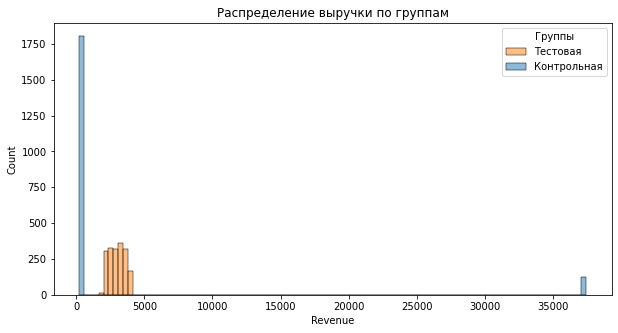

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(x = 'revenue', data = df.query('revenue > 0'), hue = 'testgroup')
plt.title('Распределение выручки по группам')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.legend(title='Группы', labels = ['Тестовая', 'Контрольная'])
plt.show()
#Наблюдается большая разница между 2-мя группами, так в контрольной группе большая
#часть пользователей является низкобюджетной, но в то же время есть выброс.
#В тестовой группе более высокобюджетные юзеры и распределены более равномерно, чем в тестовой

In [16]:
#проверка на нормальность распределения показывает, что в обеих группах ненормальное распределение
pg.normality(data = df, dv = "revenue", group = "testgroup", method = "normaltest")

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


In [17]:
#критерий Левена
pg.homoscedasticity(data = df, dv = "revenue", group = "testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


In [18]:
pg.anova(data = df, dv = "revenue", between = "testgroup")

,Source,ddof1,ddof2,F,p-unc,np2
0,testgroup,1,404768,0.389629,0.532495,9.625973e-07


In [19]:
# p-value>0,05, следовательно статистичеки значимых различий между 2 группами ARPU нет

In [20]:
# Посмотрим есть ли статистические различия между ARPPU
pg.normality(data = df.query("revenue > 0"), dv = "revenue", group = "testgroup", method = "normaltest")
# Опять наблюдается ненормальное распределение

,W,pval,normal
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


In [21]:
#Критерий Левена
pg.homoscedasticity(data = df.query("revenue > 0"), dv = "revenue", group = "testgroup")

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


In [22]:
# Выборки имеют разные дисперсии, поэтому воспользуемся t-критерией Уэлча

In [23]:
ttest_ind(df.query('testgroup == "a" and revenue > 0').revenue, 
          df.query('testgroup == "b" and revenue > 0').revenue, equal_var = False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

In [24]:
# И опять p-value>0,05, следовательно статистичеки значимых различий между 2 группами ARPPU нет

In [25]:
#проверим на стат. значимость CR с помощью хи-квадрат
conversion = []
for i in df['revenue']:
    if i > 0:
        x = '1'
    else:
        x = '0'
    conversion.append(x)
df['conversion'] = conversion
stats.chi2_contingency(pd.crosstab(df.testgroup, df.conversion))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

In [26]:
#полученное расчетное значение p-value<0,05, следовательно отклоняем нулевую теорию о отсутствии стат.значимых различий

In [27]:
#используем метод бутстрапа

In [28]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.median, 
    bootstrap_conf_level = 0.95 
    ):
    """
    числовые значения первой выборки
    числовые значения второй выборки
    количество бутстрэп-подвыборок
    интересующая нас статистика
    уровень значимости 
    """
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [29]:
data_column_1 = df.query('testgroup == "a" and revenue > 0').revenue
data_column_2 = df.query('testgroup == "b" and revenue > 0').revenue
#H0 в том, что разница не яляется стат. значимой,
#H1 - разница между группами является стат.значимой
    

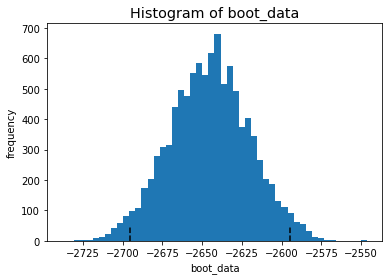

In [30]:
booted_data = get_bootstrap(data_column_1, data_column_2, boot_it = 10000, bootstrap_conf_level = 0.95, statistic=np.median)

Значение p-value на имеющихся данных позволяет отклонить нулевую гипотезу об отсутствии статистически значимом различии между распределениями.

In [31]:
print(booted_data["p_value"])
print(booted_data["ci"])
#из полученных данных делаем вывод, что различия стат. значимы

0.0
            0
0.025 -2695.5
0.975 -2595.0


In [32]:
df4

,testgroup,money_users,ARPPU,users_count,ARPU,CR
0,a,1928,2663.9984,202103,25.4137,0.95
1,b,1805,3003.6582,202667,26.7513,0.89


Выводы: по итогам проведенных анализов не было выявлено стат. значимового различия в ARPPU и ARPU в контрольной и тестовой группах. Однако стат.значимыми оказались показатели CR и медианный доход. 
    Если в сплитование было проведено верно, и дорогие покупки не ялвяются выбросами, то следует принять набор предложений А(из контрольной группы). В противном случае нужно использовать тестовый вариант.